# Modelos de Regresión Logística

## 1. Introducción a la Regresión Logística

Se trata de un **algoritmo estadístico** cuyo objetivo es aproximar una **función matemática acotada** en el intervalo [0, 1]. Así permite la estimación de las **probabilidades de pertenencia** de cada muestra a las distintas clases. Como la detección de sexismo es un problema de clasificación binario, se establece el umbral en 0.5 con el que asignar una clase a cada instancia aplicando las siguientes casuísticas:

* Si la probabilidad es **menor que 0.5** entonces la clase es **no sexista** (categoría 0). 
* Si la probabilidad es **mayor que 0.5** entonces la clase es **sexista** (categoría 1).

### 1.1. Condiciones de uso

* **Mínima correlación** entre los predictores o variables independientes.
* La existencia de una **relación lineal** entre los predictores y la probabilidad de cada variable dependiente.
* Mínima existencia de **outliers**.
* Conjunto de datos razonáblemente amplio.

### 1.2. Casos de uso

1. Construir **modelos lineales** para solventar problemas de clasificación cuyos datos son fácilmente separables.

2. Comprobar de la existencia de **relaciones lineales** entre los predictores y la variable dependiente en función de los valores de los coeficientes del hiperplano.

   - Si es 0 significa que **no existe una relación lineal** entre un predictor y la variable dependiente por lo que dicho predictor no ayuda en su predicción.

   - Si es mayor que 0 supone un crecimiento simultáneo del predictor al aumentar la variable dependiente, mientras que si es menor que 0 simboliza el incremento del predictor cuando disminuye la variable dependiente. Aunque en ambos casos el **predictor puede ser útil para predecir** la clase de una muestra.

## 2. Estructura del notebook

1. Introducción a la Regresión Logística
2. Estructura del notebook
3. Instalación y carga de librerías
4. Lectura y carga de datos
5. Técnicas de codificación de textos
6. Experimentos y modelos
7. Conclusiones

## 3. Instalación y carga de librerías

Este apartado tiene como único propósito cargar las librerías y dependencias necesarias para la ejecución de este notebook, así como las funciones propiamente desarrolladas. Previo a ello deberán ser instaladas bien ejecutando el script *setup.sh* mediante el comando `bash setup.sh` con permisos de ejecución en distribuciones Linux, o bien ejecutando el compando `pip install -r requirements.txt`.

In [1]:
%%capture
# Import LR models and validation metrics
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Import plot lib to show the confussion matrixes
import matplotlib.pyplot as plt

import sys
sys.path.append('../scripts')

# Import data read and compute functions
from data import *

# Import text preprocess functions
from processing import *

# Import encoding functions
from encoding import *

2023-05-09 12:13:23.035165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 12:13:23.851668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-09 12:13:23.851733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-09 12:13:23.851761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## 4. Lectura y carga de datos

En esta sección se pretende **cargar los datasets de entrenamiento y validación** procedentes de los correspondientes ficheros situados en la carpeta *data*. Al tener un **formato TSV** se deben leer como tablas aunque posteriormente se trabaje con ellos en formato *dataframe*. 

Tal y como se puede comprobar en los siguientes resultados las dimensiones de sendos conjuntos de datos se detallan a continuación:

* Conjunto de entrenamiento: **6.977 muestras**.
* Conjunto de validación: **4.368 muestras**.

In [2]:
# Read EXIST datasets
train_df = read_train_dataset()
test_df = read_test_dataset()

# Show the dimensions of the datasets
print('train dataset dimensions:', train_df.shape)
print('test dataset dimensions:', test_df.shape)

train dataset dimensions: (6977, 7)
test dataset dimensions: (4368, 7)


## 5. Técnicas de codificación de textos

### 5.1. Bolsa de palabras

Es una técnica orientada a la **extracción de características** basada en **texto** que convierte cada documento en un vector de longitud fija a partir del cálculo de la frecuencia de sus términos. Si bien se trata de un procedimiento altamente sencillo y rápido de aplicar, **no** respeta el **orden de los términos** en los documentos y como consecuencia tampoco considera el **contexto** de los mismos.

### 5.2. TF-IDF

Este procedimiento trata de codificar un conjunto de documentos considerando tanto la **frecuencia de los términos** en los textos como su **importancia relativa** con respecto a la población completa. Para ello calcula las frecuencias relativas y absolutas de todo el vocabulario disponible con las que posteriormente determina el **grado de relevancia y representatividad** de los términos. Este método suele beneficiar con un mayor valor a aquellos conceptos con un menor número de ocurrencias. 

### 5.3. Word Embeddings

El cometido de este método consiste en codificar **documentos o palabras** como vectores numéricos capturando las **características contextuales** en base a sus relaciones, definiciones de términos, similitudes semánticas y sintácticas. La cualidad más destacable es su capacidad de **detectar entidades similares** y generar representaciones numéricas altamente parecidas. Si bien se pueden **entrenar modelos** personalizados en conjuntos de datos, también existen **modelos pre-entrenados** con *embeddings* ya generados listos para ser utilizados.

#### 5.3.1. Generación de Word Embeddings

Existen multitud de técnicas con diferentes enfoques para el entrenamiento y creación de representaciones numéricas vectoriales a partir de documentos y las que se han decidido experimentar en este notebook se detallan a continuación:

* **Word2Vec**: es una de las técnicas más populares para codificar a nivel de palabras. Los dos siguientes algoritmos son los que se encuentran disponibles para entrenar un modelo de esta tipología.

   * **CBWO** (*Continuous Bag of Words*): esta primera arquitectura trata de **predecir el siguiente término dentro de un contexto determinado**. Se encuentra recomendada para **conjuntos de datos voluminosos** puesto que considera únicamente un vecindario de términos y tiende a representar mejor **conceptos frecuentes**.

   * **Skip-Gram**: esta segunda arquitectura trata de **predecir los contextos asociados a un término** de entrada. Puede ser empleada sobre **conjuntos de datos pequeños** para detectar **diferentes significados** por palabra.

* **Doc2Vec**: se trata de una versión muy similar a la técnica anterior aunque añadiendo un nuevo **vector numérico** que representa los **párrafos** existentes en los **documentos**. A continuación se presentan los dos algoritmos disponibles que se pueden aplicar para entrenar un modelo mediante esta técnica.

   * **PV-DM** (*Distributed Memory Version of Paragraph Vector*): aplica métodos de **Aprendizaje No Supervisado** para aprender **vectores de características de tamaños estáticos** a partir de diferentes tipos de textos de longitud variable, como frases, párrafos y documentos. Así mediante las representaciones de los párrafos se compone un **contexto** que ayuda a **predecir el siguiente término** dentro de los documentos. Es un enfoque similar al *CBWO* de la técnica anterior.

   * **PV-DBOW** (*Distributed Bag of Words Version of Paragraph Vector*): este algoritmo comparte el modo de **funcionamiento del método anterior** aunque basado en la técnica previa denominada *Skip-Gram*, en la que se entrena un modelo para **predecir el contexto** de un documento en función de un conjunto términos.

### 5.3.2. Generación de Word Embeddings

Un segundo enfoque para emplear word embeddings en la clasificación de textos consiste en utilizar **word embeddings pre-entrenados** sobre diferentes conjuntos de datos y configuraciones de modelos. Entre la multitud de ventajas que presenta esta aproximación se encuentra la idea de hacer uso de representaciones numéricas listas para utilizarse en *'cualquier problema'*, así como la existencia de distintas versiones basadas en distintas longitudes de poblaciones y técnicas de entrenamiento. Los modelos experimentados pertenencen a la librería `gensim`.

## 6. Experimentos y modelos

A continuación se detallan los experimentos más relevantes de entre las distintas pruebas realizadas mediante diversas combinaciones de técnicas de procesamiento de textos y codificación de documentos empleando la Regresión Logística, como algoritmo clásico de Aprendizaje Automático, para sentar una base con la que comenzar a idear una solución a este problema de clasificación. 

La siguiente función ha sido desarrollada exclusívamente para este notebook con la intención de realizar una validación común a todos los modelos de Regresión Logística construidos acorde a distintas configuraciones,

In [3]:
def validate_lr_model(lr_model: LogisticRegression, 
    train_labels: list, train_preds: list, 
    test_labels: list, test_preds: list):
    '''
    Computes some validation metrics using a provided trained
    Logistic Regression model as well as the true class labels 
    and the predictions over the train and test datasets.

    Parameters
    ----------
    lr_model : LogisticRegression
        A trained Logistic Regression model to validate.
    train_labels : list
        A list of numeric values with the true train class labels.
    train_preds : list
        A list of numeric values with the predictions performed by the
        trained model over the train dataset.
    test_labels : list
        A list of numeric values with the true test class labels.
    test_preds : list
        A list of numeric values with the predictions performed by the
        trained model over the test dataset.

    Returns
    -------
    None.
    '''
    # LR model validation over the train dataset
    print('Train accuracy: %.3f' %metrics.accuracy_score(
        y_true=train_labels, 
        y_pred=train_preds))
    
    # Area of the ROC curve for the train dataset
    print('Train AUC: %.3f' %metrics.roc_auc_score(
        y_true=train_labels, 
        y_score=train_preds))

    # LR model validation over the test dataset
    print('Test accuracy: %.3f' %metrics.accuracy_score(
        y_true=test_labels, 
        y_pred=test_preds))

    # Area of the ROC curve for the test dataset
    print('Test AUC: %.3f' %metrics.roc_auc_score(
        y_true=test_labels, 
        y_score=test_preds))

    # Create and plot a confusion matrix for the test dataset
    ConfusionMatrixDisplay(
        confusion_matrix=metrics.confusion_matrix(
            y_true=test_labels, 
            y_pred=test_preds), 
        display_labels=lr_model.classes_).plot(cmap='Blues')
    plt.show()

### 6.1. Primer experimento: Bolsa de palabras

Tal y como se explica en ambas competiciones, se realiza una **distinción entre textos en inglés y español** puesto que parece ser que estos últimos se caracterizan por una mejor representación y por ende, los **clasificadores entrenados únicamente sobre documentos españoles demuestran una mayor capacidad de predicción**.

#### 6.1.1. Modelo específico para inglés

- **Procesamiento** de los conjuntos de entrenamiento y validación, incluyendo las siguientes técnicas:

  - Elimina URLs.
  - Elimina usuarios mencionados.
  - Elimina caracteres especiales, no alfabéticos y signos de puntuación.
  - Convierte todos los caracteres en minúsculas.
  - **No se aplica lematización** puesto que el rendimiento del modelo aumenta únicamente en un 1% en las métricas de evaluación aunque el gasto temporal y computacional se dispara exponencialmente.
  - **No se intenta detectar y corregir palabras erróneamente escritas** puesto que tampoco mejora el rendimiento del modelo pero la inversión de recursos es desorbitada. Según he podido comprobar apenas se detecta un 9,43% de términos con faltas de ortogragía y solo un 7,61% son corregidos, por lo que esta técnica no parece que vaya a ser de utilidad. </p>

- **Codificación** de la variable dependiente *task1* a **etiquetas numéricas** en los conjuntos de entrenamiento y validación, estableciendo la asignación *non-sexist*~0 y *sexist*~1.

- Generación de una **bolsa de palabras** para entrenamiento y otra para validación como codificación de documentos en valores numéricos.

- Entrenamiento, hiperparametrización y validación con **Regresión Logística** para la construcción de varios modelos, siendo la siguiente configuración la que mejores resultados de validación ha conseguido:

  - **Regularización L1** es la penalización que ha conseguido el *accuracy* y área sobre la curva ROC más elevados gracias a su tendencia de minimizar los coeficientes a cero. Mientras que con la **regularización L2** se consiguen también unos **resultados similares**, si no se aplica penalización ambas métricas descienden más de 5 puntos. Por lo tanto se concluye que la **aplicación de regularización** para un modelo de tales características y sobre este conjunto de datos es necesaria para **reducir el overfitting**, ya que el *accuracy* de entrenamiento es muy superior al de validación.

  - El **valor de la penalización** establecido que mejor rendimiento proporciona se encuentra **muy cercano a cero**, siendo el intervalo posible [0, infinito]. Este hecho nos indica que para aumentar la capacidad de predicción de un modelo con Regresión Logística y el conjunto de datos EXIST2022, es necesario aplicar una **fortísima penalización** con motivo de **reducir el overfitting** que tiende a aparecer.

In [4]:
# Process train documents and encode the train class labels
train_df = process_texts_encode_labels(
    dataset=train_df,
    text_col='text',
    class_col='task1',
    lemmatize=False,
    correct_words=False)

# Distinguish between English and Spanish texts
es_train_df = train_df[train_df['language'] == 'es']
en_train_df = train_df[train_df['language'] == 'en']

# Process test documents and encode the train class labels
test_df = process_texts_encode_labels(
    dataset=test_df,
    text_col='text',
    class_col='task1',
    lemmatize=False,
    correct_words=False)

# Distinguish between English and Spanish texts
es_test_df = test_df[test_df['language'] == 'es']
en_test_df= test_df[test_df['language'] == 'en']

# Convert train and test documents to bag of words
en_train_bag_words, en_test_bag_words = to_bag_of_words(
    train_docs=list(en_train_df['clean_text'].values), 
    test_docs=list(en_test_df['clean_text'].values))

# Create and configure a LR model
en_lr_model = LogisticRegression(
    multi_class='ovr', 
    solver='liblinear', 
    penalty='l1', 
    C=0.3)

# Train the LR model
en_lr_model.fit(
    X=en_train_bag_words, 
    y=list(en_train_df['task1'].values))

# Predict over the train and test datasets
en_train_preds = en_lr_model.predict(X=en_train_bag_words)
en_train_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_train_bag_words)]

# Predict over the test dataset
en_test_preds = en_lr_model.predict(X=en_test_bag_words)
en_test_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_test_bag_words)]

Tal y como se observa en los siguientes resultados que representan la validación del modelo orientado a textos ingleses, sobre el conjunto de **entrenamiento** consigue un **77% de aciertos**, mientras que para el de **test** únicamente alcanza un **70% de aciertos**. Por lo tanto parece que la configuración de los datos y del clasificador en este experimento particular no proporcionan una solución de calidad a este problema de clasificación.

Si se estudia la matriz de confusión se aprecia la existencia de una **alta concentración de falsos negativos**, puesto que más de cuatrocientos textos ingleses sexistas no han sido detectados por el modelo. Este fenómeno ya se poddía anticipar durante la recopilación de información sobre los conjuntos de datos, ya que dependiendo del lenguaje utilizado en los documentos, su identificación puede llegar a ser bastante compleja de realizar automáticamente.

Train accuracy: 0.772
Train AUC: 0.769
Test accuracy: 0.700
Test AUC: 0.705


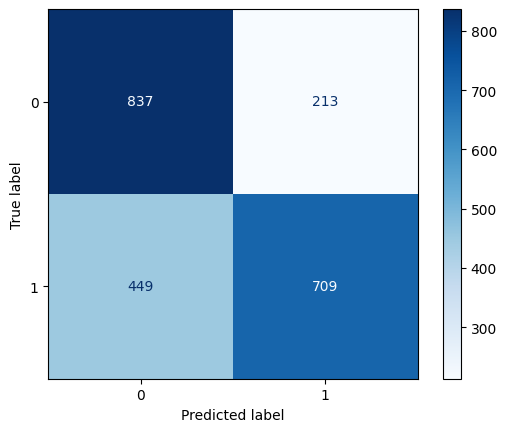

In [5]:
validate_lr_model(
    lr_model=en_lr_model, 
    train_labels=list(en_train_df['task1'].values), 
    train_preds=en_train_preds, 
    test_labels=list(en_test_df['task1'].values),
    test_preds=en_test_preds)

Si analizamos los resultados en mayor profundidad podemos observar que tanto la **mayor parte de falsos negativos como falsos positivos** se caracterizan por un **umbral de confianza medio-alto** en un intervalo [0.4, 0.8], lo que parece no ser favorable puesto que el **modelo se muestra razonáblemente seguro en los errores que comete**.

In [5]:
# Insert the predicted classes and probabilities into the test dataset
en_test_df['task1_pred_classes'] = en_test_preds
en_test_df['task1_pred_probs'] = en_test_probs

print('FALSE NEGATIVES')
false_negatives_df = en_test_df[(en_test_df['task1'] == 1) & (en_test_df['task1_pred_classes'] == 0)]
analyze_predicted_probs(
    dataset=false_negatives_df,
    probs_col='task1_pred_probs')

print('\nFALSE POSITIVES')
false_positives_df = en_test_df[(en_test_df['task1'] == 0) & (en_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')

FALSE NEGATIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 163 samples
Confidence Interval High (0.6, 0.8): 260 samples
Confidence Interval Very high (0.8, 1.0): 26 samples

FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 94 samples
Confidence Interval High (0.6, 0.8): 80 samples
Confidence Interval Very high (0.8, 1.0): 39 samples


Observando en detalle los falsos negativos, es decir las muestras positivas erróneamente clasificadas. En los siguientes resultados se puede apreciar que la **gran mayoría de ejemplos mal clasificados** pertenecen a las **categorías sexistas más complicadas de detectar**, según se pudo descubrir en el análisis de datos realizado en el *eda.ipynb*, debido a que su contenido no es suficientemente violento y explícito como para que un modelo sea capaz de detectarlo automáticamente.

In [7]:
false_negatives_df.groupby(['task2']).count().filter(['id']).sort_values(by=['id'], ascending=False)

,id
task2,
ideological-inequality,133
stereotyping-dominance,102
misogyny-non-sexual-violence,92
sexual-violence,76
objectification,46


Finalmente cruzando los falsos positivos y negativos con el análisis de emociones realizado en el notebook *eda.ipynb* se puede apreciar en los siguientes resultados que las **dos emociones mayoritarias son *anger* y *joy***. Según una inspección visual, he podido comprobar que *anger* dispone de documentos que contienen un **alto porcentaje de ironía y diversidad de temáticas** cuyo vocabulario alude más a otros tópicos como la iglesia, la lucha LGTBI, la política, el racismo, etc. Minetras qye la segunda emoción *joy* contiene muestras con **terminología positiva** aunque con **significados tremendamente negativos** desde un **punto de vista ideológico**. Tras una inspección visual de los documentos categorizados dentro de las otras dos emociones he podido concluir que la gran mayoría de ellos contienen un **alto porcentaje de ironía y diversidad de temáticas** cuyo vocabulario alude más a otros tópicos como la iglesia, la lucha LGTBI, la política, el racismo, etc.

In [8]:
print('FALSE NEGATIVES')
map_texts_to_emotions(
    text_ids=list(false_negatives_df['id'].values),
    is_test=True
)

print('\nFALSE POSITIVES')
map_texts_to_emotions(
    text_ids=list(false_positives_df['id'].values),
    is_test=True
)

FALSE NEGATIVES
Emotion: anger - No. of texts: 214
Emotion: love - No. of texts: 6
Emotion: joy - No. of texts: 111
Emotion: fear - No. of texts: 47
Emotion: sadness - No. of texts: 63
Emotion: surprise - No. of texts: 8

FALSE POSITIVES
Emotion: anger - No. of texts: 94
Emotion: love - No. of texts: 2
Emotion: joy - No. of texts: 63
Emotion: fear - No. of texts: 25
Emotion: sadness - No. of texts: 27
Emotion: surprise - No. of texts: 2


#### 6.1.2. Modelo específico para español

Reproduciendo la misma configuración de datos, entrenamiento y validación, a continuación se construye un modelo similar al anterior aunque basado en los textos españoles. Tal y como se aprecia en los siguientes resultados, **todas las métricas tanto del conjunto de entrenamiento como de test son ligeramente inferiores** a las encontradas en el clasificador dedicado a textos en inglés. Por lo tanto, de momento no se demuestra que las muestras en español dispongan de una mejor representetividad que ayude a mejorar la capacidad de predicción de un modelo con Regresión Logística.

Analizando la matriz de confusión se observa que es prácticamente idéntica a la mostrada anteriormente y las conclusiones extraídas del caso anterior son aplicables al clasificador en español, si bien el código no se añade de nuevo puesto que no aporta nueva información útil.

Train accuracy: 0.768
Train AUC: 0.768
Test accuracy: 0.682
Test AUC: 0.687


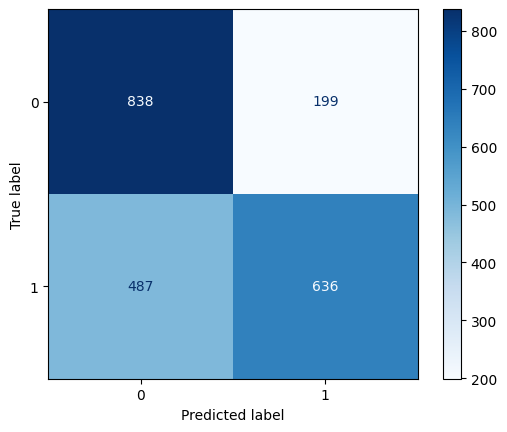

In [7]:
# Convert train and test documents to bag of words
es_train_bag_words, es_test_bag_words = to_bag_of_words(
    train_docs=list(es_train_df['clean_text'].values), 
    test_docs=list(es_test_df['clean_text'].values))

# Create and configure a LR model
es_lr_model = LogisticRegression(
    multi_class='ovr', 
    solver='liblinear', 
    penalty='l1', 
    C=0.3)

# Train the LR model
es_lr_model.fit(
    X=es_train_bag_words, 
    y=list(es_train_df['task1'].values))

# Predict over the train and test datasets
es_train_preds = es_lr_model.predict(X=es_train_bag_words)

# Predict over the test dataset
es_test_preds = es_lr_model.predict(X=es_test_bag_words)

# Validate the Spanish model
validate_lr_model(
    lr_model=es_lr_model, 
    train_labels=list(es_train_df['task1'].values), 
    train_preds=es_train_preds, 
    test_labels=list(es_test_df['task1'].values),
    test_preds=es_test_preds)

### 6.2. Segundo experimento: TF-IDF

#### 6.2.1. Modelo específico para inglés

La configuración tanto de los datasets como del modelo son idénticas a las explicadas en el anterior experimento, a excepción de los dos siguientes aspectos:

* La **codificación de textos** se ha realizado aplicando la técnica denominada **TF-IDF**. 

* La **regularización** escogida en este caso ha sido la **L2** con un valor de penalización por defecto establecido en 1.0 puesto que al aumentarlo (menos penalización) el sobreajuste incrementaba considerablemente, mientas que al decrementar el valor (más penalización) el rendimiento del modelo empeoraba ligeramente.

In [10]:
# Encode train and test documents as TF-IDF vectors
en_train_tfidf, en_test_tfidf = to_tf_idf(
    train_docs=list(en_train_df['clean_text'].values), 
    test_docs=list(en_test_df['clean_text'].values))

# Create and configure a LR model
en_lr_model = LogisticRegression(
    multi_class='ovr', 
    solver='liblinear')

# Train the LR model
en_lr_model.fit(
    X=en_train_tfidf, 
    y=list(en_train_df['task1'].values))

# Predict over the train and test datasets
en_train_preds = en_lr_model.predict(X=en_train_tfidf)
en_train_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_train_tfidf)]

# Predict over the test dataset
en_test_preds = en_lr_model.predict(X=en_test_tfidf)
en_test_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_test_tfidf)]

Tal y como se puede observar en los siguientes resultados, este segundo modelo parece caracterizarse por un **mayor sobreajuste** que el anterior puesto que la tasa de aciertos de entrenamiento es más de 14 puntos con respecto al conjunto de test. Adicionalmente en la matriz de confusión se observa una **mayor acentuación sobre el número de falsos negativos** aumentando la cifra de textos sexistas no detectados.

Un aspecto interesante ha sido la posibilidad de ajustar la configuración de entrenamiento obteniendo distintos resultados tras involucrar a una nueva técnica de codificación de textos. Con la misma **configuración anterior** el modelo del segundo experimento disponía de un **menor sobreajuste pero también un menor rendimiento**, mientras que con esta nueva configuración se dispara la tasa de aciertos en entrenamiento mientras que se resiente considerablemente en validación.

Train accuracy: 0.877
Train AUC: 0.876
Test accuracy: 0.691
Test AUC: 0.694


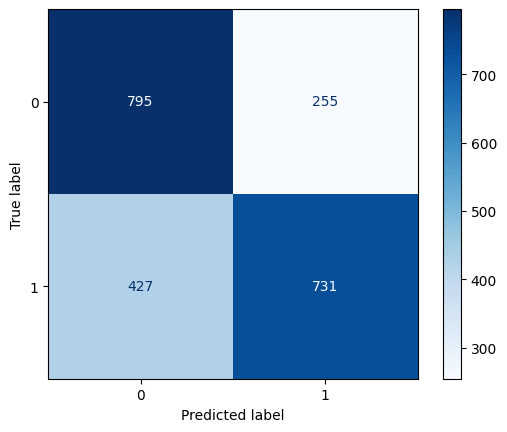

In [11]:
# Validate the Spanish model
validate_lr_model(
    lr_model=en_lr_model, 
    train_labels=list(en_train_df['task1'].values), 
    train_preds=en_train_preds, 
    test_labels=list(en_test_df['task1'].values),
    test_preds=en_test_preds)

Replicando el mismo procedimiento de análisis realizado en la primera sección relativa al uso de bolsas de palabras, podemos apreciar en los siguientes resultados la **misma tendencia** en cada uno de los estudios realizados. Por lo tanto las **conclusiones extraídas hasta el momento también son aplicables** sobre estos experimentos que emplean la técnica TF-IDF para la codificación de documentos.

In [12]:
# Insert the predicted classes and probabilities into the test dataset
en_test_df['task1_pred_classes'] = en_test_preds
en_test_df['task1_pred_probs'] = en_test_probs

# Map probabilities to confidence intervals
print('FALSE NEGATIVES')
false_negatives_df = en_test_df[(en_test_df['task1'] == 1) & (en_test_df['task1_pred_classes'] == 0)]
analyze_predicted_probs(
    dataset=false_negatives_df,
    probs_col='task1_pred_probs')

print('\nFALSE POSITIVES')
false_positives_df = en_test_df[(en_test_df['task1'] == 0) & (en_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')

# Count the number of false negatives per sexist category
print(false_negatives_df.groupby(['task2']).count().filter(['id']).sort_values(by=['id'], ascending=False))

# Map texts to emotions
print('\nFALSE NEGATIVES')
map_texts_to_emotions(
    text_ids=list(false_negatives_df['id'].values),
    is_test=True
)

print('\nFALSE POSITIVES')
map_texts_to_emotions(
    text_ids=list(false_positives_df['id'].values),
    is_test=True
)

FALSE NEGATIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 222 samples
Confidence Interval High (0.6, 0.8): 199 samples
Confidence Interval Very high (0.8, 1.0): 6 samples

FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 133 samples
Confidence Interval High (0.6, 0.8): 113 samples
Confidence Interval Very high (0.8, 1.0): 9 samples
                               id
task2                            
ideological-inequality        139
stereotyping-dominance         97
misogyny-non-sexual-violence   83
sexual-violence                74
objectification                34

FALSE NEGATIVES
Emotion: anger - No. of texts: 204
Emotion: love - No. of texts: 5
Emotion: joy - No. of texts: 106
Emotion: fear - No. of texts: 51
Emotion: sadness - No. of texts: 54
Emotion: surprise - No. of texts: 7

FALSE PO

#### 6.2.2. Modelo específico para español

Acorde a los siguientes resultados tras entrenar un clasificador con la misma configuración definida en este experimento aunque sobre los documentos en español, se aprecia **un mayor sobreajuste** puesto que la diferencia entre las métricas de entrenamiento y de test son aún más destacables. En relación a las conclusiones obtenidas a partir del análisis de las probabilidades, las categorías sexistas y las emociones, de nuevo se han observado los **mismos patrones conocidos hasta el momento**, por lo que no se incluye el código puesto que no aportan más información relevante.

Train accuracy: 0.970
Train AUC: 0.970
Test accuracy: 0.678
Test AUC: 0.681


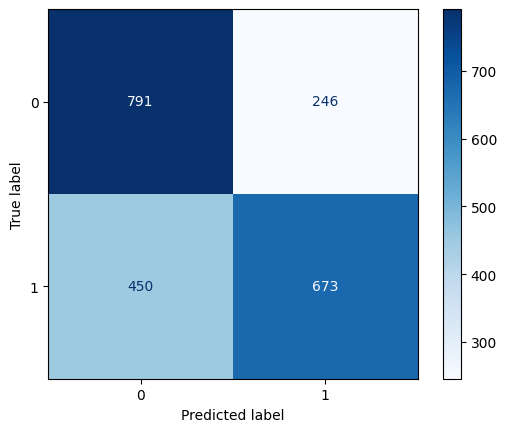

In [13]:
# Convert train and test documents to bag of words
es_train_tfidf, es_test_tfidf = to_tf_idf(
    train_docs=list(es_train_df['clean_text'].values), 
    test_docs=list(es_test_df['clean_text'].values))

# Create and configure a LR model
es_lr_model = LogisticRegression(
    multi_class='ovr', 
    solver='liblinear')

# Train the LR model
es_lr_model.fit(
    X=es_train_bag_words, 
    y=list(es_train_df['task1'].values))

# Predict over the train and test datasets
es_train_preds = es_lr_model.predict(X=es_train_bag_words)

# Predict over the test dataset
es_test_preds = es_lr_model.predict(X=es_test_bag_words)

# Validate the Spanish model
validate_lr_model(
    lr_model=es_lr_model, 
    train_labels=list(es_train_df['task1'].values), 
    train_preds=es_train_preds, 
    test_labels=list(es_test_df['task1'].values),
    test_preds=es_test_preds)

### 6.3. Tercer experimento: generación de embeddings

#### 6.3.1. Codificación con Word2Vec

En este nuevo experimento la configuración de los conjuntos de datos es similar a las anteriores así como la del propio modelo de Regresión Logística, destacando los siguientes aspectos:

* La **codificación de textos** se ha realizado aplicando la técnica denominada **Word2Vec** para generar *word embeddings* personalizados a los datasets. 

* La **regularización** escogida en este caso ha sido la **L2** puesto que se presenta una casuística parecida a la explicada en el experimento anterior.

Tras probar diversos valores para los distintos parámetros de la codificación de textos se han podido obtener las siguientes conclusiones:

* El rango para el parámetro *vector_size* se encuentra alrededor de 100 por lo que es necesario aumentar el tamaño de los embeddings para almacenar una **mayor cantidad de vocabulario** con la que posteriormente codificar los documentos de una manera más precisa y sin perder tanta información que con longitudes menores.

* El valor del parámetro *min_count* también es relevante puesto que si **aumenta demasiado el vocabulario** puede contener **demasiado ruido** y por ende las representaciones resultantes perjudican el rendimiento del clasificador. No obstante, si el valor es muy elevado el **vocabulario se reduce drásticamente perdiendo información**.

* Una situación similar ocurre con el número de **iteraciones** puesto que a **mayor número, más sobreajuste** puesto que mayor es la diferencia entre los aciertos de entrenamiento y validación, aunque si se **decrementa demasiado** el modelo puede no tener suficiente tiempo como para estudiar los datos y perder información **disminuyendo su rendimiento**.

* En relación al algoritmo utilizado para la codificación ha sido **CBWO** el que mejores resultados ha proporcionado siendo hasta un 5% más elevado en las tres métricas escogidas con respecto al algoritmo Skip-Gram. Por lo tanto para este conjunto de datos y utilizando Regresión Logística, es más factible intentar **predecir el siguiente término a partir del contexto** que no aplicando la arquitectura inversa.

* Finalmente se ha experimentado a entrenar un único modelo Word2Vec generando un vocabulario con sendos datasets, con únicamente el de entrenamiento o dos modelos, uno para cada conjunto. De las tres configuraciones la que mejores valores métricos ha conseguido ha sido la última en la que se entrena **un modelo Word2Vec por dataset**. Una de las posibles teorías explicativas de este fenómeno reside en que si bien el conjunto de entrenamiento solo está compuesto por *tweets*, el de validación también dispone de documentos procedentes de una segunda red social llamada *Gab* y un alto contenido en noticias, por lo que la **terminología** parece ser **considerablemente diferente entre datasets**.

##### 6.3.1.1. Modelo específico para inglés

A pesar de los distintos experimentos realizados utilizando *word-embeddings* para encontrar la codificación de textos más prometedora para entrenar un clasificador con Regresión Logística, según se muestran en los siguientes resultados el modelo se encuentra **completamente sesgado por la clase negativa** ya que todas las predicciones realizadas han sido hacia la categoría *non-sexist*. Este fenómeno es observable cláramente en la matriz de confusión pueso que únicamente existen falsos negativos y verdaderos negativos.

Train accuracy: 0.554
Train AUC: 0.543
Test accuracy: 0.476
Test AUC: 0.500


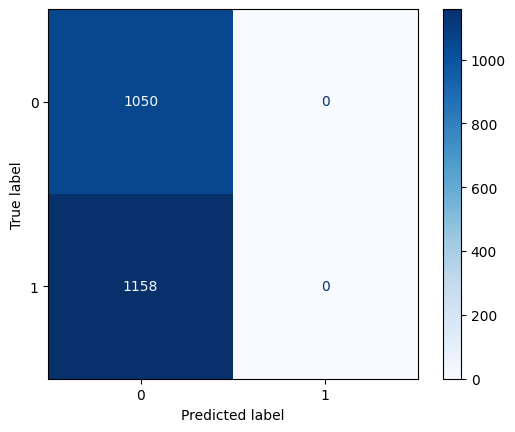

In [14]:
# Encode train and test documents as word-embeddings
en_train_w2v, en_test_w2v = word2vec_pipeline(
    train_df=en_train_df, 
    train_text_col='clean_text', 
    test_df=en_test_df, 
    test_text_col='clean_text',
    vector_size=100, 
    window=2, 
    min_count=4, 
    epochs=7, 
    alg=0)

# Create and configure a LR model
en_lr_model = LogisticRegression(
    multi_class='ovr', 
    solver='liblinear')

# Train the LR model
en_lr_model.fit(
    X=en_train_w2v, 
    y=list(en_train_df['task1'].values))

# Predict over the train and test datasets
en_train_preds = en_lr_model.predict(X=en_train_w2v)
en_train_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_train_w2v)]

# Predict over the test dataset
en_test_preds = en_lr_model.predict(X=en_test_w2v)
en_test_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_test_w2v)]

validate_lr_model(
    lr_model=en_lr_model, 
    train_labels=list(en_train_df['task1'].values), 
    train_preds=en_train_preds, 
    test_labels=list(en_test_df['task1'].values), 
    test_preds=en_test_preds)

##### 6.3.1.2. Modelo específico para español

Tal y como se aprecia en los siguientes resultados después de la construcción de un clasificador con la misma configuración anterior aunque sobre el conjunto de documentos en español, la tendencia se modifica puesto que en este caso en base a las métricas de validación se determina que el modelo generado es **completamente aleatorio**, proporcionando resultados diferentes en distintas ejecuciones.

Train accuracy: 0.579
Train AUC: 0.576
Test accuracy: 0.501
Test AUC: 0.496


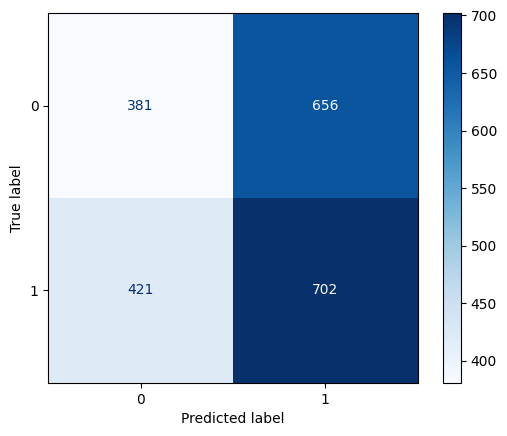

In [15]:
# Encode train and test documents as word-embeddings
es_train_w2v, es_test_w2v = word2vec_pipeline(
    train_df=es_train_df, 
    train_text_col='clean_text', 
    test_df=es_test_df, 
    test_text_col='clean_text',
    vector_size=100, 
    window=2, 
    min_count=4, 
    epochs=7, 
    alg=0)

# Create and configure a LR model
es_lr_model = LogisticRegression(
    multi_class='ovr', 
    solver='liblinear')

# Train the LR model
es_lr_model.fit(
    X=es_train_w2v, 
    y=list(es_train_df['task1'].values))

# Predict over the train and test datasets
es_train_preds = es_lr_model.predict(X=es_train_w2v)
es_train_probs = [max(prob) for prob in es_lr_model.predict_proba(X=es_train_w2v)]

# Predict over the test dataset
es_test_preds = es_lr_model.predict(X=es_test_w2v)
es_test_probs = [max(prob) for prob in es_lr_model.predict_proba(X=es_test_w2v)]

validate_lr_model(
    lr_model=es_lr_model, 
    train_labels=list(es_train_df['task1'].values), 
    train_preds=es_train_preds, 
    test_labels=list(es_test_df['task1'].values), 
    test_preds=es_test_preds)

#### 6.3.2. Codificación con Doc2Vec

Al igual que con la versión anterior se replica la misma configuración de los conjuntos de entrenamiento y validación para entrenar un modelo con Regresión Logística destacando los siguientes aspectos más relevantes:

* La **codificación de textos** se ha realizado aplicando la técnica denominada **Doc2Vec** para generar *word embeddings* personalizados a los datasets. 

* La **regularización** escogida en este caso ha sido la **L2** con un valor ligeramente superior al valor por defecto por lo que aplicando una **menor penalización** el modelo presenta **mejores resultados**. Tanto con una mayor penalización como aplicando la regularización L1, los resultados de las métricas descienden hasta en más de 3 puntos. 

Tras probar diversos valores para los distintos parámetros de la codificación de textos se han podido obtener las siguientes conclusiones:

* El rango para el parámetro *vector_size* es más elevado que con la técnica *Word2Vec* necesitando **vectores de mayor longitud** para encapsular más información que ayude al modelo a obtener un mejor rendimiento. La teoría explicativa más plausible para este aumento de tamaño puede estar relacionada con la característica adicional que presenta esta variante al incluir la **representación de los párrafos** en los que se encuentran los términos, ya que ocupan una mayor longitud que los propios conceptos.

* El valor del parámetro *min_count* también ha **aumentado su valor** para mejorar el rendimiento del modelo por lo que parece necesario **restringir más los términos** que aparecen en el vocabulario que en la variante anterior. Así se obtiene un vocabulario más preciso pese a que la representación de los textos ocupe una mayor cantidad de memoria.

* Una situación similar ocurre con el número de **iteraciones** puesto que a **mayor número, más sobreajuste** puesto que mayor es la diferencia entre los aciertos de entrenamiento y validación, aunque si se **decrementa demasiado** el modelo puede no tener suficiente tiempo como para estudiar los datos y perder información **disminuyendo su rendimiento**.

* Mientras que los experimentos con el algoritmo **PV-DBOW apenas han hecho variar el rendimiento del modelo**, la segunda opción **PV-DM** es la que ha proporcionado una **mayor variabilidad y respuesta** ante los cambios de los parámetros y por ende el mejor modelo encontrado para esta configuración. De nuevo el enfoque de entrenamiento de *embeddings* que parece ser más efectivo es la **predicción de términos a partir de un contexto** proporcionado.

##### 6.3.2.1. Modelo específico para inglés

A pesar de las diferencias destacadas entre ambas técnicas, este nuevo clasificador resultante también presenta un **comportamiento prácticamente aleatorio** por sus ínfimas tasas de aciertos tanto en entrenamiento como en validación, además de un valor AUC casi despreciable que confirma el nulo aprendizaje del modelo. Como en el experimento previo destaca una **fortísima tasa de falsos positivos** si observamos la matriz de confusión.

Train accuracy: 0.522
Train AUC: 0.500
Test accuracy: 0.532
Test AUC: 0.513


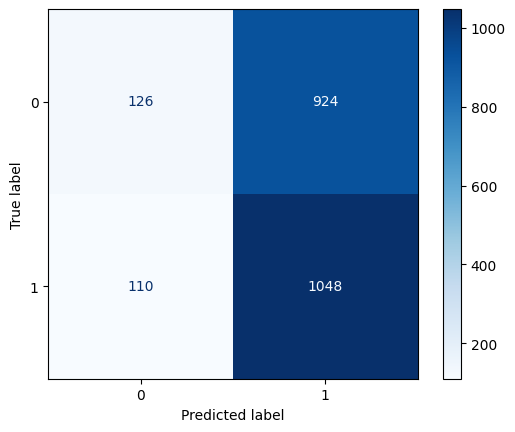

In [16]:
# Encode train and test documents as word-embeddings
en_train_d2v, en_test_d2v = doc2vec_pipeline(
    train_df=en_train_df, 
    train_text_col='clean_text', 
    test_df=en_test_df, 
    test_text_col='clean_text', 
    vector_size=200, 
    window=5, 
    min_count=10, 
    epochs=2, 
    alg=1)

# Create and configure a LR model
en_lr_model = LogisticRegression(
    multi_class='ovr', 
    solver='liblinear', 
    penalty='l2', 
    C=1.5)

# Train the LR model
en_lr_model.fit(
    X=en_train_d2v, 
    y=list(en_train_df['task1'].values))

# Predict over the train and test datasets
en_train_preds = en_lr_model.predict(X=en_train_d2v)
en_train_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_train_d2v)]

# Predict over the test dataset
en_test_preds = en_lr_model.predict(X=en_test_d2v)
en_test_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_test_d2v)]

validate_lr_model(
    lr_model=en_lr_model, 
    train_labels=list(en_train_df['task1'].values), 
    train_preds=en_train_preds, 
    test_labels=list(en_test_df['task1'].values), 
    test_preds=en_test_preds)

A diferencia de los modelos construidos hasta el momento, en los siguientes datos estadísticos se puede observar que el clasificador entrenado sobre documentos en inglés codificados con *Doc2Vec* se caracteriza por unos **umbrales de confianza medios y bajos**, por lo que parece ser que el modelo en este experimento no se encuentra seguro de las predicciones que realiza.

In [17]:
# Insert the predicted classes and probabilities into the test dataset
en_test_df['task1_pred_classes'] = en_test_preds
en_test_df['task1_pred_probs'] = en_test_probs

# Map probabilities to confidence intervals
print('FALSE NEGATIVES')
false_negatives_df = en_test_df[(en_test_df['task1'] == 1) & (en_test_df['task1_pred_classes'] == 0)]
analyze_predicted_probs(
    dataset=false_negatives_df,
    probs_col='task1_pred_probs')

print('\nFALSE POSITIVES')
false_positives_df = en_test_df[(en_test_df['task1'] == 0) & (en_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')

FALSE NEGATIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 97 samples
Confidence Interval High (0.6, 0.8): 13 samples
Confidence Interval Very high (0.8, 1.0): 0 samples

FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 920 samples
Confidence Interval High (0.6, 0.8): 4 samples
Confidence Interval Very high (0.8, 1.0): 0 samples


No obstante, en el resto de análisis explicativos las **métricas calculadas son muy similares** a las de otros modelos y tras una inspección visual de los documentos implicados, se pueden **aplicar las mismas conclusiones** conocidas hasta el momento acerca de la naturaleza y composición de los textos relativos a muestras erróneamente clasificadas.

In [18]:
# Count the number of false negatives per sexist category
print(false_negatives_df.groupby(['task2']).count().filter(['id']).sort_values(by=['id'], ascending=False))

# Map texts to emotions
print('\nFALSE NEGATIVES')
map_texts_to_emotions(
    text_ids=list(false_negatives_df['id'].values),
    is_test=True
)

print('\nFALSE POSITIVES')
map_texts_to_emotions(
    text_ids=list(false_positives_df['id'].values),
    is_test=True
)

                              id
task2                           
misogyny-non-sexual-violence  34
sexual-violence               24
objectification               19
stereotyping-dominance        19
ideological-inequality        14

FALSE NEGATIVES
Emotion: anger - No. of texts: 43
Emotion: love - No. of texts: 12
Emotion: joy - No. of texts: 16
Emotion: fear - No. of texts: 20
Emotion: sadness - No. of texts: 19

FALSE POSITIVES
Emotion: anger - No. of texts: 367
Emotion: love - No. of texts: 15
Emotion: joy - No. of texts: 307
Emotion: fear - No. of texts: 114
Emotion: sadness - No. of texts: 102
Emotion: surprise - No. of texts: 19


##### 6.3.2.2. Modelo específico para español

Visualizando los siguientes resultados tras construir un clasificador con idéntica configuración a la anterior aunque sobre un conjunto de textos españoles, podemos apreciar un cambio drástico de comportamiento obteniendo un **modelo totalmente sesgado hacia la clase positiva**, según la matriz de confusión.

Train accuracy: 0.525
Train AUC: 0.519
Test accuracy: 0.520
Test AUC: 0.500


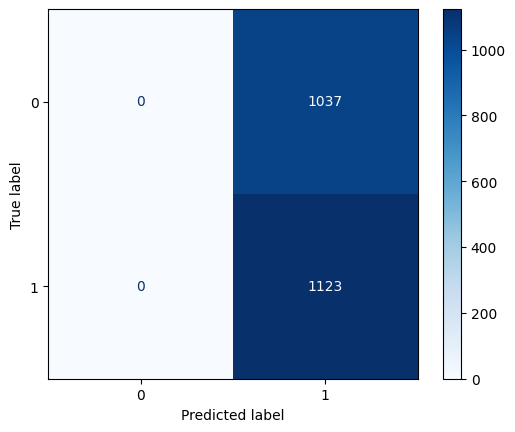

In [19]:
# Encode train and test documents as word-embeddings
es_train_d2v, es_test_d2v = doc2vec_pipeline(
    train_df=es_train_df, 
    train_text_col='clean_text', 
    test_df=es_test_df, 
    test_text_col='clean_text', 
    vector_size=200, 
    window=5, 
    min_count=10, 
    epochs=2, 
    alg=1)

# Create and configure a LR model
es_lr_model = LogisticRegression(
    multi_class='ovr', 
    solver='liblinear', 
    penalty='l2', 
    C=1.5)

# Train the LR model
es_lr_model.fit(
    X=es_train_d2v, 
    y=list(es_train_df['task1'].values))

# Predict over the train and test datasets
es_train_preds = es_lr_model.predict(X=es_train_d2v)
es_train_probs = [max(prob) for prob in es_lr_model.predict_proba(X=es_train_d2v)]

# Predict over the test dataset
es_test_preds = es_lr_model.predict(X=es_test_d2v)
es_test_probs = [max(prob) for prob in es_lr_model.predict_proba(X=es_test_d2v)]

validate_lr_model(
    lr_model=es_lr_model, 
    train_labels=list(es_train_df['task1'].values), 
    train_preds=es_train_preds, 
    test_labels=list(es_test_df['task1'].values), 
    test_preds=es_test_preds)

Observando el siguiente análisis sobre los intervalos de confianza existentes en los falsos positivos se aprecia una concentración total en el rango [0.4, 0.6], lo que significa que el **modelo no se encuentra nada seguro acerca de las predicciones que realiza**.

In [20]:
# Insert the predicted classes and probabilities into the test dataset
es_test_df['task1_pred_classes'] = es_test_preds
es_test_df['task1_pred_probs'] = es_test_probs

print('\nFALSE POSITIVES')
false_positives_df = es_test_df[(es_test_df['task1'] == 0) & (es_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')


FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 1037 samples
Confidence Interval High (0.6, 0.8): 0 samples
Confidence Interval Very high (0.8, 1.0): 0 samples


### 6.3.4. Embeddings pre-entrenados

En esta última sección se ha experimentado con diferentes modelos pre-entrenados que disponen de un conjunto de embeddings listo para codificar los documentos de entrenamiento y validación. A continuación se exponen los resultados que se han obtenido de manera general y específica a ciertos modelos.

* La mayoría de modelos experimentados **generan valores peridos** al intentar codificar los documentos de entrenamiento y validación, por lo que su tratamiento debe ser considerado para el empleo de ciertos algoritmos de Aprendizaje Automático, como es el caso de la Regresión Logística que es totalmente incompatible con este tipo de valores.

* La mayor parte de word-embeddings pre-entrenados se encuentran únicamente **orientados a documentos en inglés**, siendo aquellos multilenguajes o específicos del español ficheros disponibles *online* de tamaños muy considerables (> 2GB). Por lo tanto para realizar una primera prueba procedemos a realizar este experimento únicamente con los textos ingleses.

Tal y como se puede apreciar en los siguientes resultados, los valores de todas las métricas de validación son pésimos, si bien parece **evitarse el fenómeno del sobreaprendizaje** por su mínima diferencia entre entrenamiento y test. No obstante, las tasas de falsos positivos y negativos siguen siendo demasiado altas por lo que de momento utilizando únicamente Regresión Logística no parece que se puedan vislumbrar las diferencias y ventajas de usar embeddings pre-entrenados o generarlos de manera personalizada a nuestro problema.

Train accuracy: 0.696
Train AUC: 0.692
Test accuracy: 0.649
Test AUC: 0.651


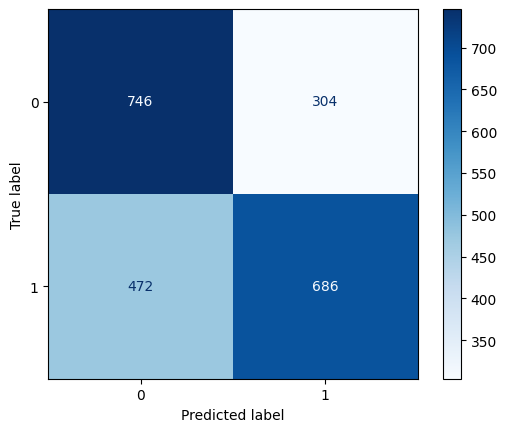

In [21]:
# Encode train and test documents as word-embeddings
en_train_pret_wordemb, en_test_pret_wordemb = to_pretrained_embeddings(
    train_df=en_train_df, 
    train_text_col='clean_text', 
    test_df=en_test_df, 
    test_text_col='clean_text', 
    model='glove-twitter-100',
    vector_size=100)

# Create and configure a LR model
en_lr_model = LogisticRegression(
    multi_class="ovr", 
    solver="liblinear")

# Train the LR model
en_lr_model.fit(
    X=en_train_pret_wordemb, 
    y=list(en_train_df['task1'].values))

# Predict over the train and test datasets
en_train_preds = en_lr_model.predict(X=en_train_pret_wordemb)
en_train_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_train_pret_wordemb)]

# Predict over the test dataset
en_test_preds = en_lr_model.predict(X=en_test_pret_wordemb)
en_test_probs = [max(prob) for prob in en_lr_model.predict_proba(X=en_test_pret_wordemb)]

validate_lr_model(
    lr_model=en_lr_model, 
    train_labels=list(en_train_df['task1'].values), 
    train_preds=en_train_preds, 
    test_labels=list(en_test_df['task1'].values), 
    test_preds=en_test_preds)

Por último replicando la misma analítica sobre las probabilidades predichas, las clases sexistas existentes y el estudio sobre detección de emociones, podemos visualizar datos muy similares a los experimentos anteriores. La **mayor parte de los errores se encuentran en los dos intervalos de confianza más elevados**, por lo que el modelo parece seguro de las decisiones que ha tomado. Por otro lado la distribución de textos entre las emociones detectadas y las categorías sexistas es prácticamente idéntica a las vistas hasta el momento, perteneciendo la **mayoría de muestras erróneamente clasificadas a las categorías más complicadas de detectar**. 

In [22]:
# Insert the predicted classes and probabilities into the test dataset
en_test_df['task1_pred_classes'] = en_test_preds
en_test_df['task1_pred_probs'] = en_test_probs

# Map probabilities to confidence intervals
print('FALSE NEGATIVES')
false_negatives_df = en_test_df[(en_test_df['task1'] == 1) & (en_test_df['task1_pred_classes'] == 0)]
analyze_predicted_probs(
    dataset=false_negatives_df,
    probs_col='task1_pred_probs')

print('\nFALSE POSITIVES')
false_positives_df = en_test_df[(en_test_df['task1'] == 0) & (en_test_df['task1_pred_classes'] == 1)]
analyze_predicted_probs(
    dataset=false_positives_df,
    probs_col='task1_pred_probs')

# Count the number of false negatives per sexist category
print(false_negatives_df.groupby(['task2']).count().filter(['id']).sort_values(by=['id'], ascending=False))

# Map texts to emotions
print('\nFALSE NEGATIVES')
map_texts_to_emotions(
    text_ids=list(false_negatives_df['id'].values),
    is_test=True
)

print('\nFALSE POSITIVES')
map_texts_to_emotions(
    text_ids=list(false_positives_df['id'].values),
    is_test=True
)

FALSE NEGATIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 221 samples
Confidence Interval High (0.6, 0.8): 232 samples
Confidence Interval Very high (0.8, 1.0): 19 samples

FALSE POSITIVES
Confidence Interval Very low (0.0, 0.2): 0 samples
Confidence Interval Low (0.2, 0.4): 0 samples
Confidence Interval Medium (0.4, 0.6): 127 samples
Confidence Interval High (0.6, 0.8): 132 samples
Confidence Interval Very high (0.8, 1.0): 45 samples
                               id
task2                            
ideological-inequality        162
stereotyping-dominance        122
misogyny-non-sexual-violence   82
sexual-violence                59
objectification                47

FALSE NEGATIVES
Emotion: anger - No. of texts: 204
Emotion: love - No. of texts: 7
Emotion: joy - No. of texts: 132
Emotion: fear - No. of texts: 44
Emotion: sadness - No. of texts: 75
Emotion: surprise - No. of texts: 10

FALSE

## 7. Conclusiones

Después de experimentar con diferentes configuraciones de codificación de textos y entrenamiento de modelos con Regresión Logística, a continuación se resumen las claves más relevantes que se han extraído durante la generación de este notebook:

* Si bien el algoritmo de Regresión Logística para entrenar los clasificadores es profundamente sencillo, el objetivo se orientaba más hacia el **estudio y comprensión de las metodologías de codificación de textos**. Por lo tanto debemos considerar que los resultados obtenidos **no permiten descartar** a unas u otras puesto que la Regresión Logística no está pensada para abordar problemas de clasificación de textos.

* De las experimentaciones realizadas destacan principalmente las dos primeras en las que se empleaban **Bolsas de Palabras** y **TF-IDF** por sus **mejores resultados** en base a las métricas consideradas de *accuracy* en entrenamiento y test, *AUC* y matriz de confusión. Si bien han sido **las más sencillas** de conocer, implementar y analizar, han demostrado disponer de una **suficiente capacidad de representación** para construir clasificadores medianamente decentes con un algoritmo estadístico como es la Regresión Logística.

* En relación al **entrenamiento de embeddings** personalizados en los conjuntos de datos se han podido experimentar con diversas técnicas que son prácticamente **todas variantes de Word2Vec**. En estos casos los **resultados no han sido aceptables** pero de nuevo intuyo un gran potencial si son combinados con arquitecturas más complejas y específicamente diseñadas para la clasificación de textos, como redes LSTM. Del mismo modo ocurre con el uso de embeddings pre-entrenados, en cuya mayoría apenas se han podido entrenar clasificadores por su generación de valores nulos y la incompatibilidad de tratar este tipo de datos por parte de la Regresión Logística.

* Una conclusión general a todos los modelos ha sido el **aumento del sobreajuste** presentado conforme **aumenta la complejidad de la codificación de textos**. Este fenómeno probablemente esté únicamente asociado al empleo de la Regresión Logística para la construcción de los clasificadores pero ha sido inesperado por mi parte y por tanto debe ser destacado como precaución a tomar en el uso de arquitecturas más complejas.